In [ ]:
!git clone https://github.com/IDEA-Research/DWPose.git
%cd DWPose/mmpose
!uw pip install -q -r requirements.txt
!uw pip install -q onnxruntime-gpu
!uw pip install -q -v -e .

In [ ]:
%cd ../ControlNet-v1-1-nightly
!gdown 12L8E2oAgZy4VACGSK9RaZBZrfgx7VTA2 -O annotator/ckpts/dw-ll_ucoco_384.onnx
!gdown 1w9pXC8tT0p9ndMN-CArp1__b2GbzewWI -O annotator/ckpts/yolox_l.onnx

/content/DWPose/ControlNet-v1-1-nightly
Downloading...
From (original): https://drive.google.com/uc?id=12L8E2oAgZy4VACGSK9RaZBZrfgx7VTA2
From (redirected): https://drive.google.com/uc?id=12L8E2oAgZy4VACGSK9RaZBZrfgx7VTA2&confirm=t&uuid=74adde1f-849f-49be-bb51-ccf9ca64c196
To: /content/DWPose/ControlNet-v1-1-nightly/annotator/ckpts/dw-ll_ucoco_384.onnx
100% 134M/134M [00:01<00:00, 126MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1w9pXC8tT0p9ndMN-CArp1__b2GbzewWI
From (redirected): https://drive.google.com/uc?id=1w9pXC8tT0p9ndMN-CArp1__b2GbzewWI&confirm=t&uuid=b6f50558-95b2-4221-b8d2-9d40f4810c7c
To: /content/DWPose/ControlNet-v1-1-nightly/annotator/ckpts/yolox_l.onnx
100% 217M/217M [00:02<00:00, 84.4MB/s]


In [ ]:
import cv2
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from annotator.dwpose.util import draw_bodypose, draw_handpose, draw_facepose
from annotator.dwpose.wholebody import Wholebody
%cd /content/DWPose/ControlNet-v1-1-nightly

/content/DWPose/ControlNet-v1-1-nightly


In [ ]:
def draw_pose(pose, H, W):
    bodies = pose['bodies']
    faces = pose['faces']
    hands = pose['hands']
    candidate = bodies['candidate']
    subset = bodies['subset']
    canvas = np.zeros(shape=(H, W, 3), dtype=np.uint8)

    canvas = draw_bodypose(canvas, candidate, subset)
    canvas = draw_handpose(canvas, hands)
    canvas = draw_facepose(canvas, faces)
    return canvas


class DWposeDetector:
    def __init__(self):
        self.pose_estimation = Wholebody()

    def __call__(self, oriImg):
        oriImg = oriImg.copy()
        H, W, C = oriImg.shape

        with torch.no_grad():
            candidate, subset = self.pose_estimation(oriImg)
            nums, keys, locs = candidate.shape
            candidate[..., 0] /= float(W)
            candidate[..., 1] /= float(H)

            body = candidate[:, :18].copy()
            body = body.reshape(nums * 18, locs)
            score = subset[:, :18]

            for i in range(len(score)):
                for j in range(len(score[i])):
                    if score[i][j] > 0.3: score[i][j] = int(18 * i + j)
                    else: score[i][j] = -1

            un_visible = subset<0.3
            candidate[un_visible] = -1
            foot = candidate[:, 18:24]
            faces = candidate[:, 24:92]
            hands = candidate[:, 92:113]
            hands = np.vstack([hands, candidate[:, 113:]])
            bodies = dict(candidate=body, subset=score)
            pose = dict(bodies=bodies, hands=hands, faces=faces)
            return draw_pose(pose, H, W)

In [ ]:
pose = DWposeDetector()
test_image = 'test_imgs/football.jpg'
oriImg = cv2.imread(test_image)  # B,G,R order

Time taken: 0.0342 seconds


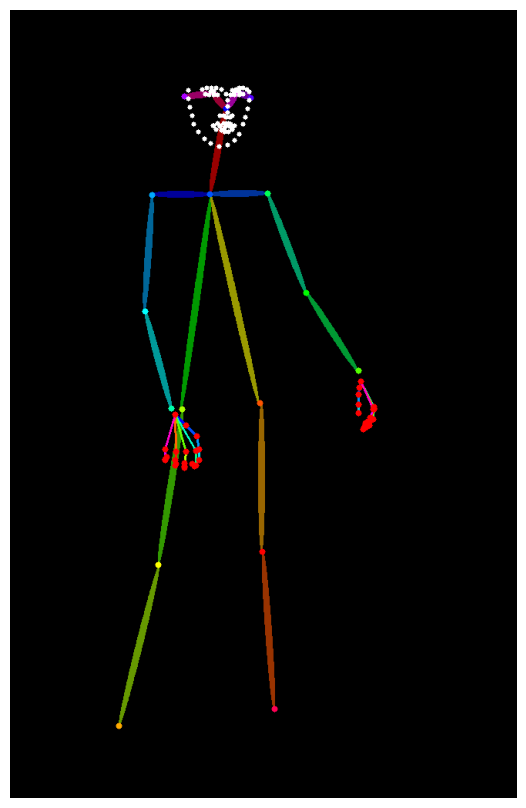

In [ ]:
start_time = time.perf_counter()
result_img = pose(oriImg)
print(f'Time taken: {time.perf_counter() - start_time:.4f} seconds')

height, width, _ = result_img.shape
fig = plt.figure(figsize = (width/100, height/100), dpi=100)
plt.imshow(result_img[:,:,::-1])
plt.axis('off')
plt.show()